In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

#AIF360 Dataset Classes 
from aif360.datasets import StandardDataset
from aif360.datasets import BinaryLabelDataset

#AIF360 Metrics Classes  
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

from aif360.metrics import ClassificationMetric

#AIF360 Algorithms 
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, EqOddsPostprocessing
# AI360 Explainers
from aif360.explainers import MetricTextExplainer

#Sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,train_test_split

#Helpers 
from src.dataset_functions import *
from src.fair_classifier_functions import *


In [2]:
salary_list = [60000, 100000, 150000, 200000, 250000, 300000, 350000]
datasets = create_multiple_datasets(create_binary_dataset_salary, salary_list)

In [3]:
privileged_groups= [{'sex':1}]
unprivileged_groups= [{'sex': 0}]
RW = Reweighing(unprivileged_groups=unprivileged_groups, 
               privileged_groups=privileged_groups)



In [4]:
rw_datasets = []
for dataset in datasets: 
    rw = RW.fit_transform(dataset)
    rw_datasets.append(rw)

In [5]:
means, impact = get_dataset_metrics_list(rw_datasets)

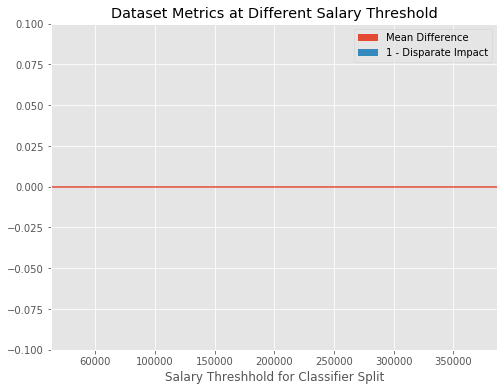

In [6]:
fig, ax = plt.subplots(figsize = (8,6))
x_axis = range(len(salary_list))

ax.bar(x_axis, means, label='Mean Difference' )
ax.bar(x_axis, impact, label='1 - Disparate Impact')
ax.axhline(0)
ax.set_xticks(x_axis)
ax.set_xticklabels(salary_list)
ax.set_title('Dataset Metrics at Different Salary Threshold')
ax.set_xlabel('Salary Threshhold for Classifier Split')
ax.set_ylim(-.1, .1)
ax.legend()
plt.savefig('images/model_rw_metrics')

In [7]:
train, val, test = create_split_lists(rw_datasets)

In [8]:
pred_list = get_rw_predictions(RandomForestClassifier(n_estimators=500, max_depth=5), train, val)

In [9]:
classifier_stats = get_classifier_metrics(val, pred_list)

In [10]:
classifier_stats

([0.992, 0.882, 0.764, 0.651, 0.731, 0.855, 0.955],
 [0.5, 0.698, 0.646, 0.607, 0.499, 0.506, 0.5],
 [0.0, -0.179, -0.129, -0.131, 0.0, 0.017, 0.0],
 [0.0, -0.042, 0.002, -0.134, 0.002, 0.034, 0.0],
 [-0.003, 0.053, 0.092, 0.1, 0.07, 1.0, 0.0])

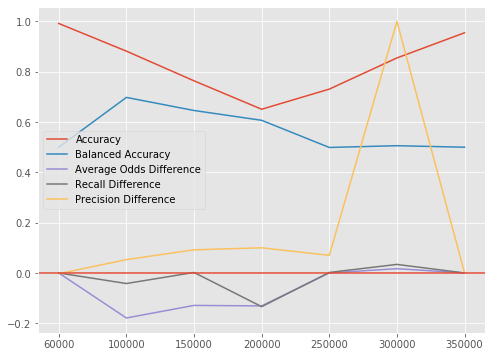

In [11]:
fig, ax = plt.subplots(figsize = (8,6))
x_axis = range(len(classifier_stats[0]))

ax.plot(x_axis, classifier_stats[0], label='Accuracy' )
ax.plot(x_axis, classifier_stats[1], label='Balanced Accuracy' )
ax.plot(x_axis, classifier_stats[2], label='Average Odds Difference' )
ax.plot(x_axis, classifier_stats[3], label='Recall Difference' )
ax.plot(x_axis, classifier_stats[4], label='Precision Difference' )

ax.axhline(0)
ax.set_xticks(x_axis)
ax.set_xticklabels(salary_list)
# ax.set_title('Dataset Metrics at Different Salary Threshold')
# ax.set_xlabel('Salary Threshhold for Classifier Split')
ax.legend()
plt.savefig('images/rw_classifier_metrics')

In [12]:
pred_mean, pred_di = get_dataset_metrics_list(pred_list)

//anaconda3/lib/python3.7/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: divide by zero encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)
//anaconda3/lib/python3.7/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)


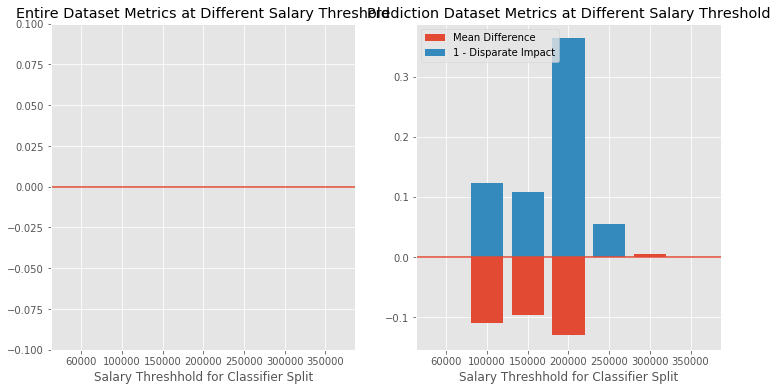

In [18]:
fig, axes = plt.subplots(1,2, figsize = (12,6))
x_axis = range(len(salary_list))

axes[0].bar(x_axis, means, label='Mean Difference' )
axes[0].bar(x_axis, impact, label='1 - Disparate Impact')
axes[0].axhline(0)
axes[0].set_xticks(x_axis)
axes[0].set_xticklabels(salary_list)
axes[0].set_title('Entire Dataset Metrics at Different Salary Threshold')
axes[0].set_xlabel('Salary Threshhold for Classifier Split')
axes[0].set_ylim(-.1, .1)

axes[1].bar(x_axis, pred_mean, label='Mean Difference' )
axes[1].bar(x_axis, pred_di, label='1 - Disparate Impact')
axes[1].axhline(0)
axes[1].set_xticks(x_axis)
axes[1].set_xticklabels(salary_list)
axes[1].set_title('Prediction Dataset Metrics at Different Salary Threshold')
axes[1].set_xlabel('Salary Threshhold for Classifier Split')
#axes[1].set_ylim()

plt.legend()
plt.savefig('images/rw_side_by_side_metrics')

In [22]:
get_bias_amplification(train[2], pred_list[2])

AttributeError: 'BinaryLabelDatasetMetric' object has no attribute 'smoothed_empirical_differential_fairness'

AttributeError: 'ClassificationMetric' object has no attribute 'differential_fairness_bias_amplification'